In [1]:
import tensorflow as tf
import cv2 
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from tensorflow.contrib.layers import layers
import glob
import os

from pylab import rcParams 
np.core.arrayprint._line_width = 160
rcParams['figure.figsize'] = 10, 20

os.chdir("/home/msmith/kaggle/ultraSound/tf/")
from loadData import *
from performance import *
from dice import *

os.chdir("/home/msmith/kaggle/ultraSound/")

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def weights(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

def mp2(x):
    return tf.nn.max_pool(x,ksize = [1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [21]:
tf.reset_default_graph() 
with tf.variable_scope("deCnn"):
    normalDim = (420,580)
    inputDim, outputDim = (128,128), (8,8)
    x = tf.placeholder(tf.float32,shape=[None,inputDim[0],inputDim[1],1])
    y_ = tf.placeholder(tf.float32,shape=[None,outputDim[0],outputDim[1],1])
    yOrig_ = tf.placeholder(tf.float32,shape=[None,normalDim[0],normalDim[1],1])

    convolutionLayers = []
    nConvolutions = 5
    nFeatsOut = 24
    nFeatsInc = 16
    for i in xrange(nConvolutions):
        if i ==0:
            nFeatsIn = 1
        elif i < nConvolutions - 1:
            nFeatsOut += nFeatsInc
        elif i == nConvolutions-1:
            nFeatsOut = 1

        W = weights([3,3,nFeatsIn,nFeatsOut])
        b = bias([nFeatsOut])
        convolutionLayers.append([W,b]) 
        nFeatsIn = nFeatsOut
        
    h1 = conv2d(x,convolutionLayers[0][0]) + convolutionLayers[0][1]
    h1_bn = tf.nn.relu(layers.batch_norm(h1))
    h1p = mp2(h1_bn)
    
    h2 = conv2d(h1p,convolutionLayers[1][0]) + convolutionLayers[1][1]
    h2_bn = tf.nn.relu(layers.batch_norm(h2))
    h2p = mp2(h2_bn)
    
    h3 = conv2d(h2p,convolutionLayers[2][0]) + convolutionLayers[2][1]
    h3_bn = tf.nn.relu(layers.batch_norm(h3))
    h3p = mp2(h3_bn)
    
    h4 = tf.nn.relu(conv2d(h3p,convolutionLayers[3][0]) + convolutionLayers[3][1])
    h4_bn = tf.nn.relu(layers.batch_norm(h4))
    h4p = mp2(h4_bn)
    
    #h5 = tf.nn.relu(conv2d(h4p,convolutionLayers[4][0]) + convolutionLayers[4][1])
    #h5_bn = tf.nn.relu(layers.batch_norm(h5))
    #h5p = mp2(h5_bn)
    h5_bn = layers.batch_norm(conv2d(h4p,convolutionLayers[4][0]) + convolutionLayers[4][1])
    
    yPred = tf.nn.sigmoid(h5_bn)

print(x.get_shape())
for i in xrange(len(convolutionLayers)):
    print(convolutionLayers[i][0].get_shape())

(?, 128, 128, 1)
(3, 3, 1, 24)
(3, 3, 24, 40)
(3, 3, 40, 56)
(3, 3, 56, 72)
(3, 3, 72, 1)


5635 train paths and 5508 test paths
Train set split into 4508 train CV paths and 1127 test CV paths
Restored model
3
3
1
24
24
3
3
24
40
40
3
3
40
56
56
3
3
56
72
72
3
3
72
1
1
24
40
56
72
1
Number of total paramters = 66338. 
Training epoch number 0.
Augmenting
Training paths length =  4508
Testing epoch number 0.yPred
Not augmenting
Testing paths length =  1127


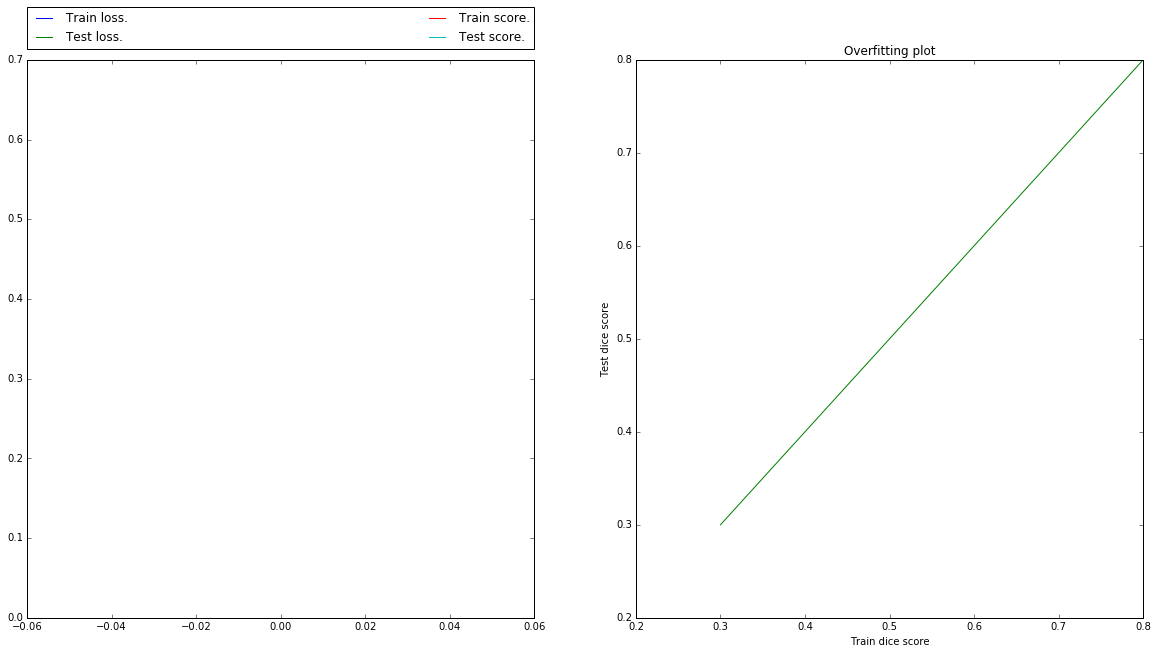

Training epoch number 1.
Augmenting
Training paths length =  4508


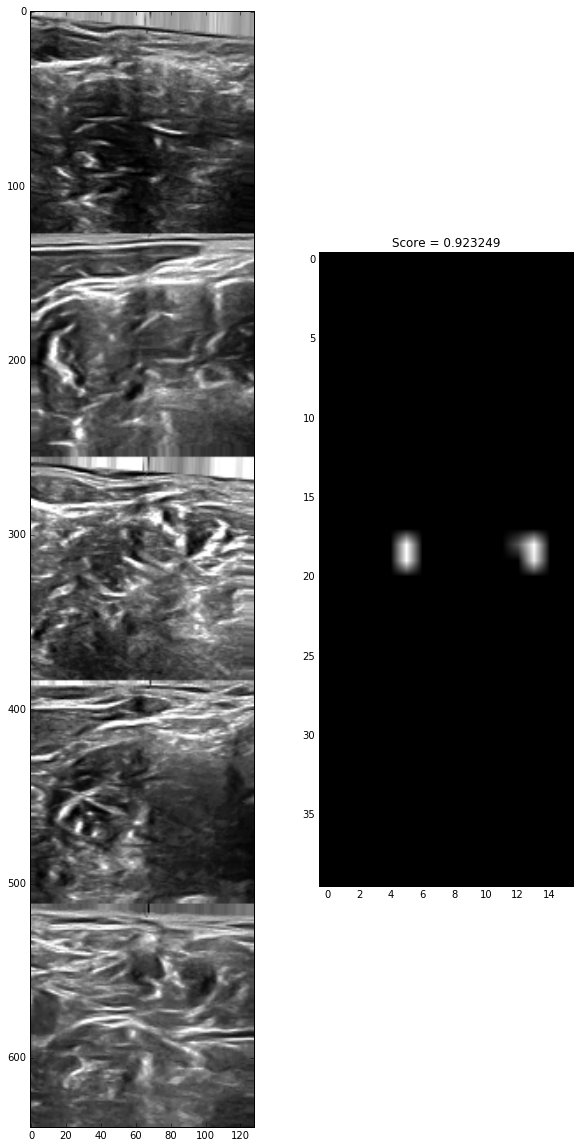

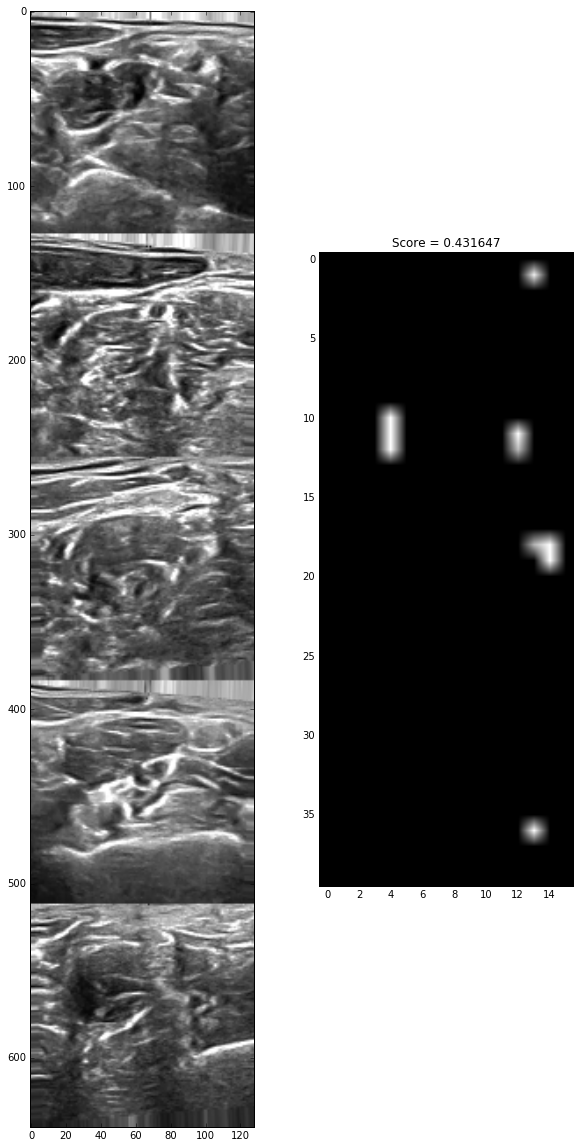

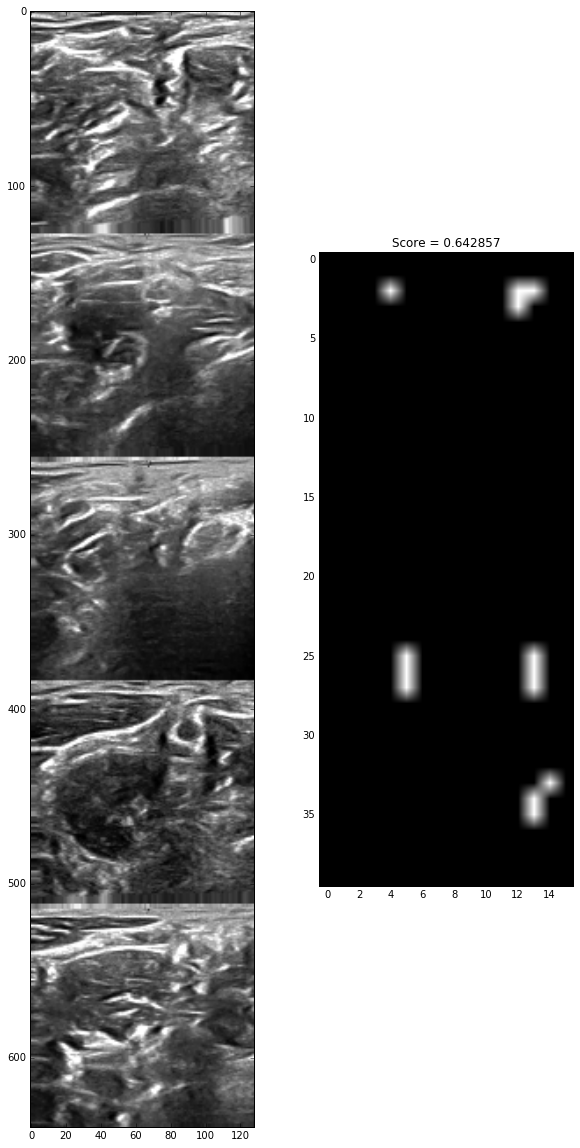

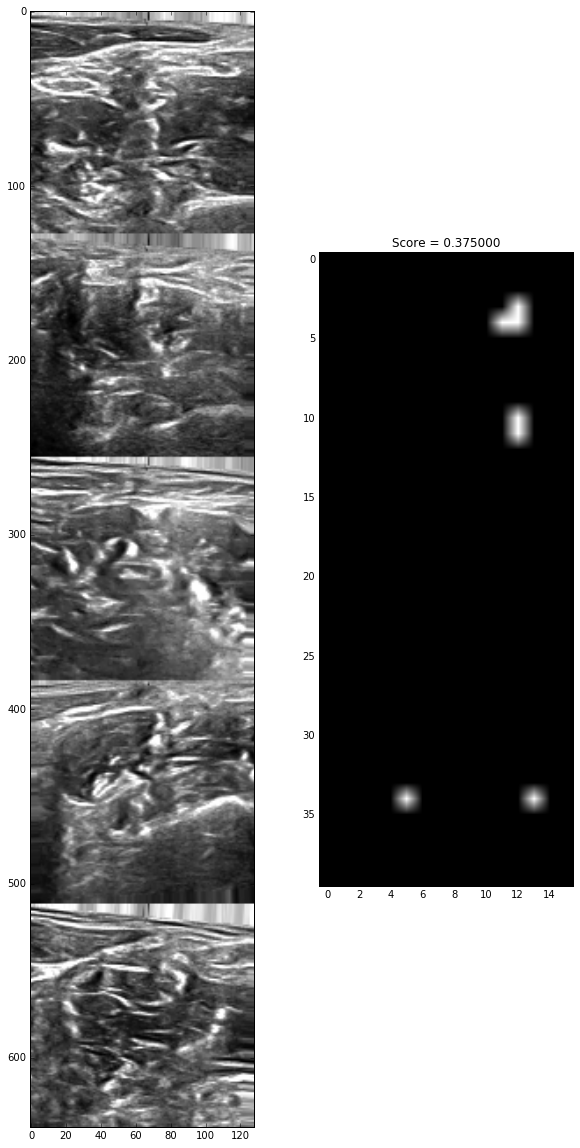

Testing epoch number 1.yPred
Not augmenting
Testing paths length =  1127


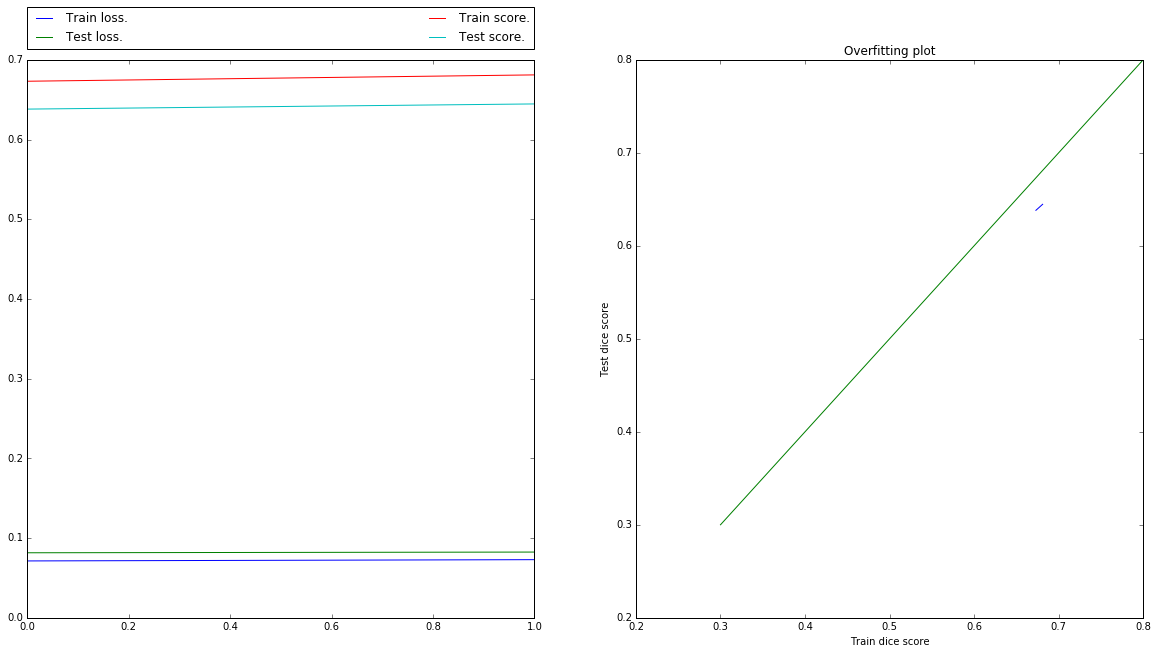

Training epoch number 2.
Augmenting
Training paths length =  4508


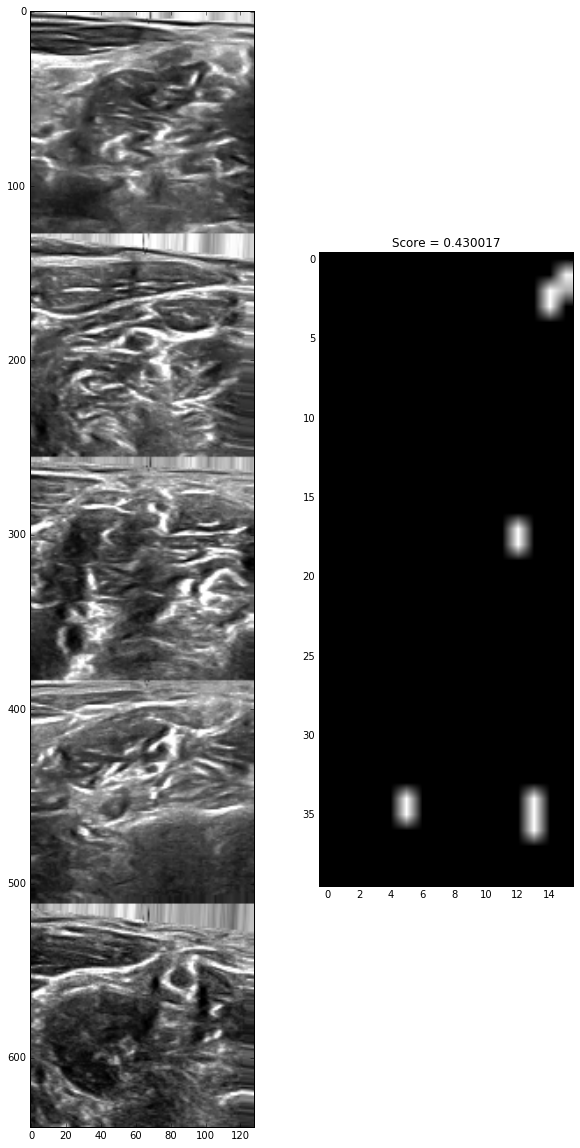

Testing epoch number 2.yPred
Not augmenting
Testing paths length =  1127


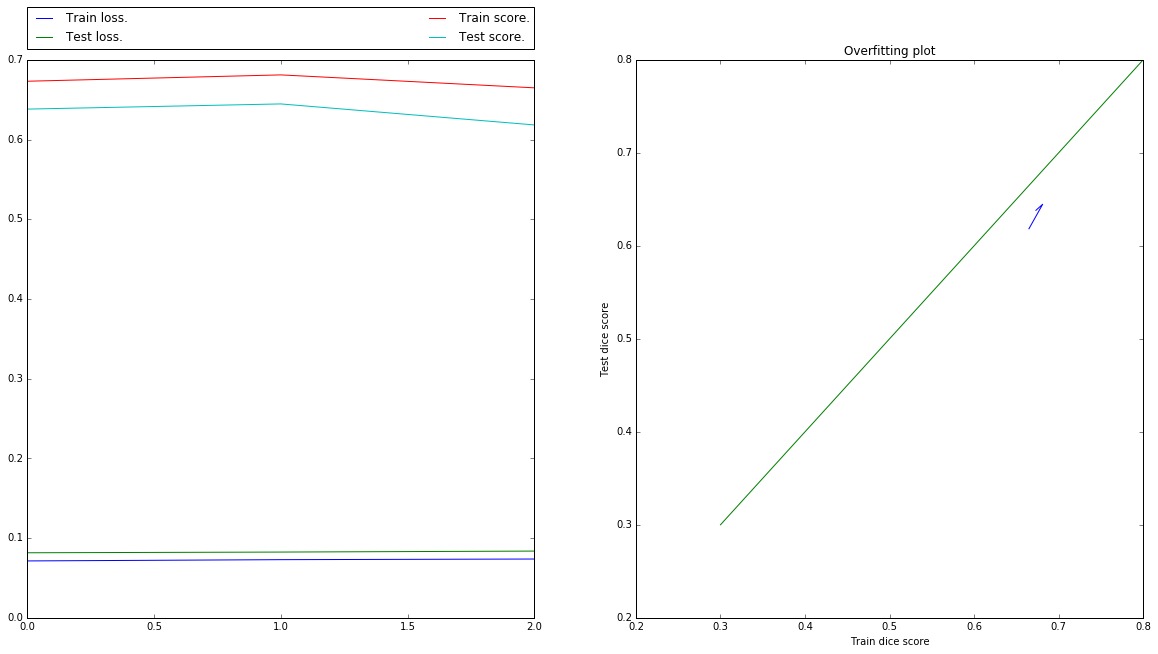

Training epoch number 3.
Augmenting
Training paths length =  4508
Testing epoch number 3.yPred
Not augmenting
Testing paths length =  1127


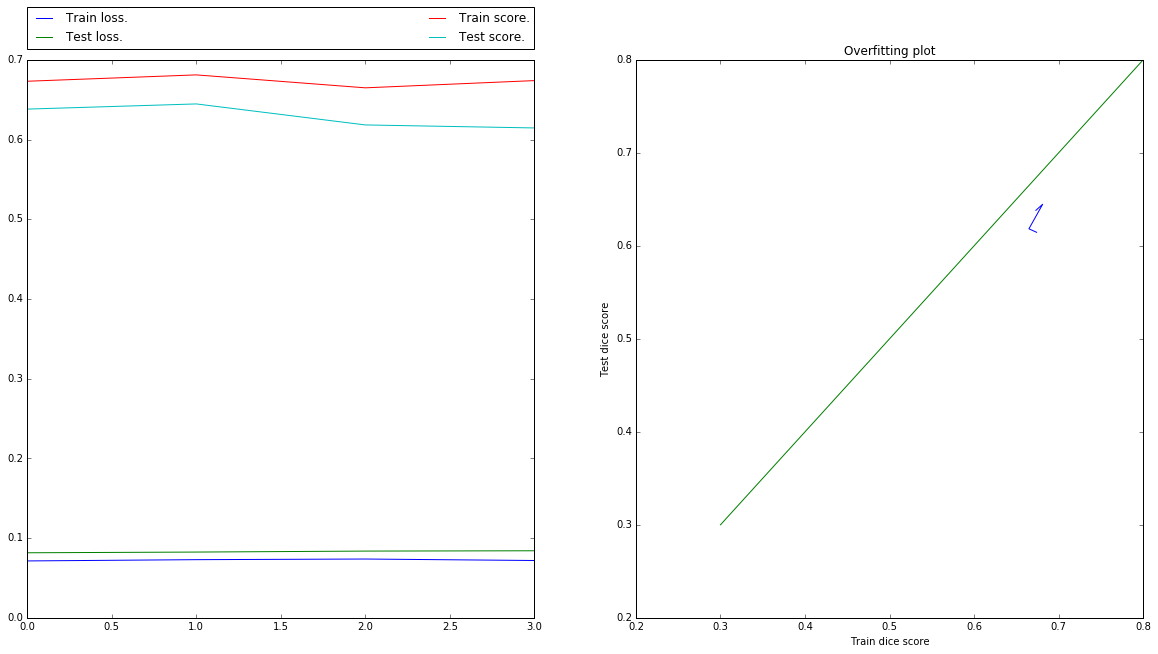

Training epoch number 4.
Augmenting
Training paths length =  4508
Testing epoch number 4.yPred
Not augmenting
Testing paths length =  1127


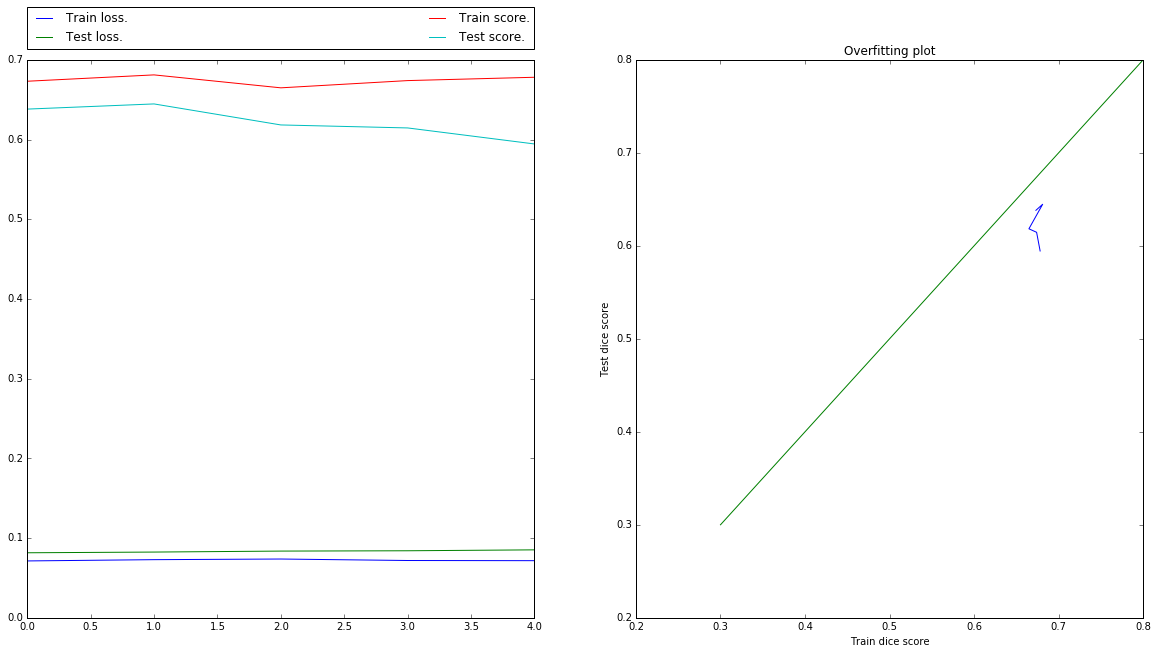

Training epoch number 5.
Augmenting
Training paths length =  4508
Testing epoch number 5.yPred
Not augmenting
Testing paths length =  1127


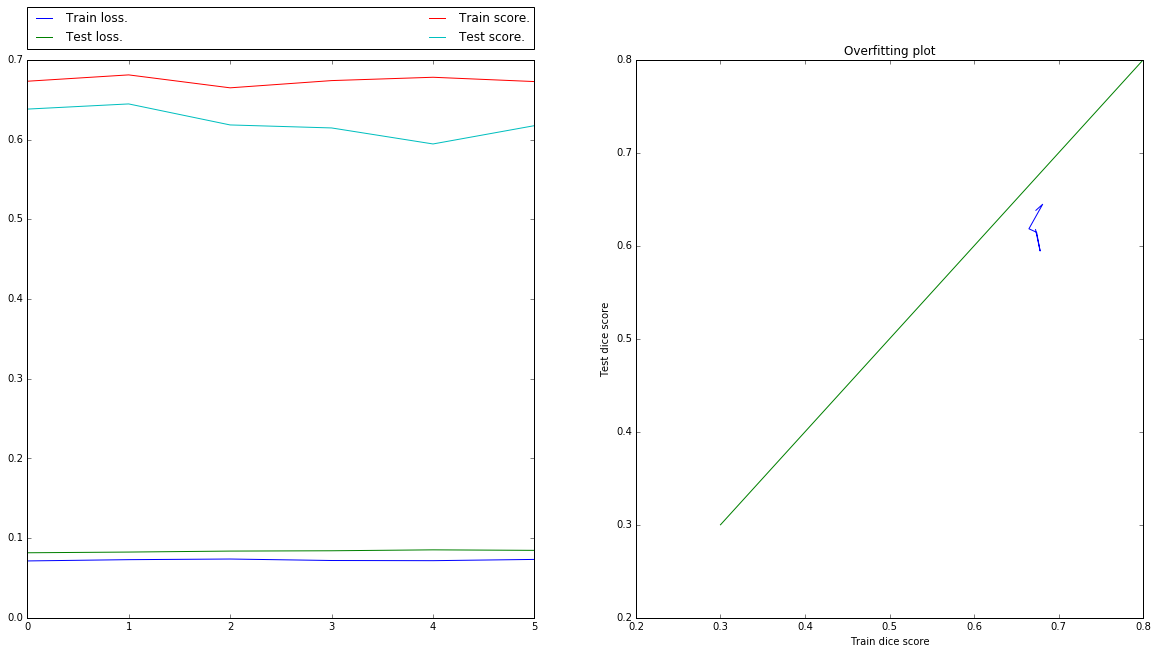

Dropped learning rate to 0.000833
Model saved in file: model.ckpt
Training epoch number 6.
Augmenting
Training paths length =  4508
Testing epoch number 6.yPred
Not augmenting
Testing paths length =  1127


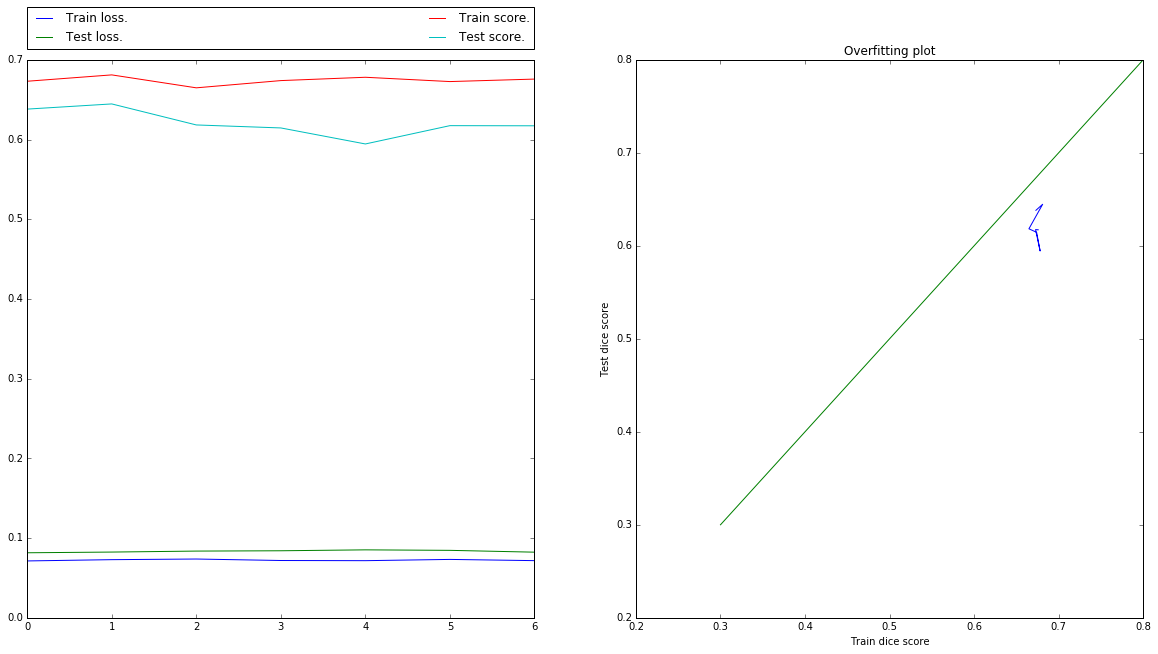

Training epoch number 7.
Augmenting
Training paths length =  4508
Testing epoch number 7.yPred
Not augmenting
Testing paths length =  1127


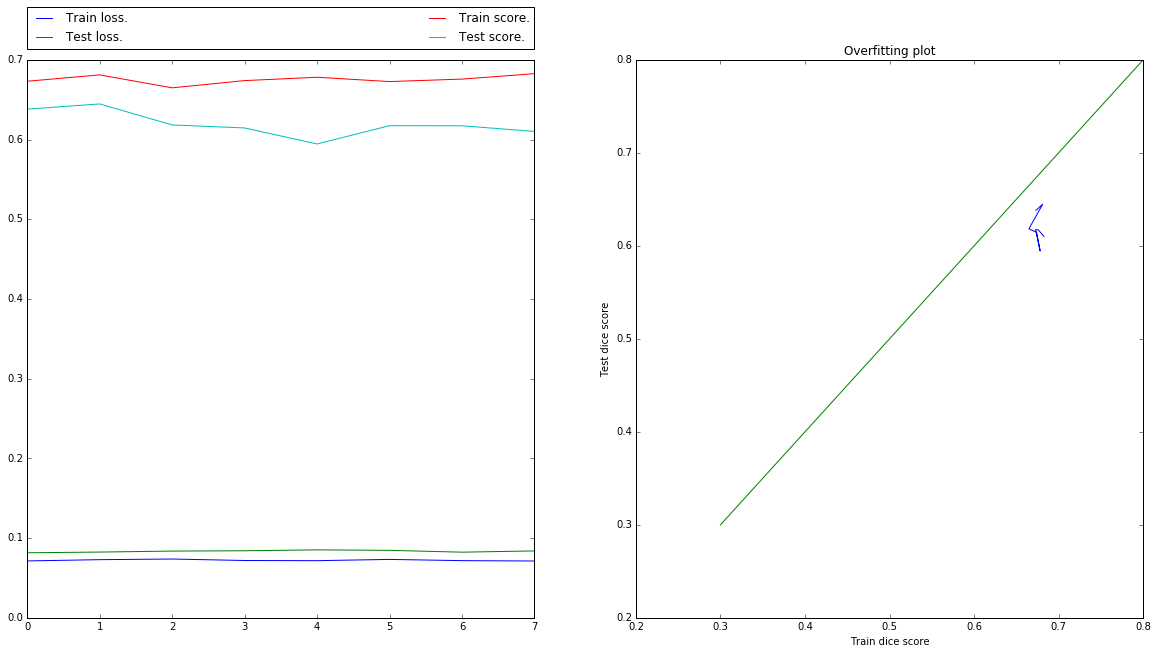

Training epoch number 8.
Augmenting
Training paths length =  4508
Testing epoch number 8.yPred
Not augmenting
Testing paths length =  1127


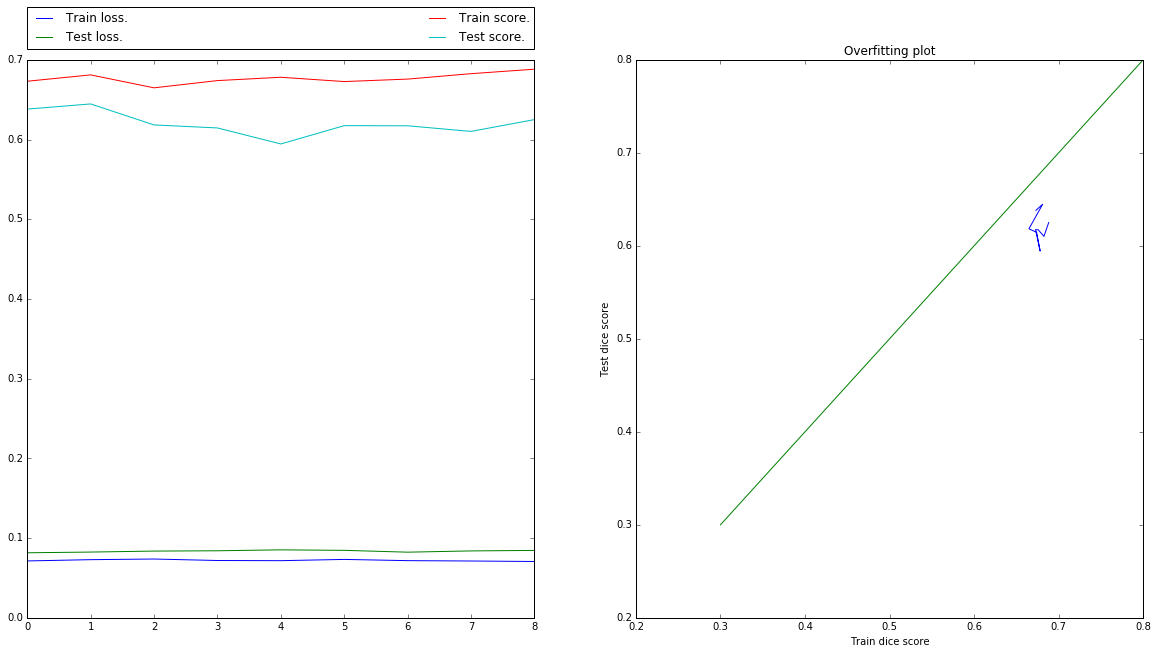

Training epoch number 9.
Augmenting
Training paths length =  4508
Testing epoch number 9.yPred
Not augmenting
Testing paths length =  1127


AttributeError: 'Tensor' object has no attribute 'squeeze'

In [22]:
if __name__ == "__main__":

    batchSize = 5
    
    
    learning_rate = tf.placeholder(tf.float32,shape=[])
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(yPred - y_),(1,2,3))/batchSize)
    opt = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon=0.0001)
    opt_operation = opt.minimize(mse)
    
    #yPredUpscale = tf.image.resize_bilinear(yPred,(normalDim))
    diceScore, yPredThresh = dice(yPred=yPred,yTruth=y_,thresh = 0.5)
    
    dataGen = dataGenerator(cvSplit = 0.8, batchSize=batchSize,inputDim=inputDim,outputDim=outputDim)
    
    epochs = 20
    lr = 0.001
    load = 1
    displayProb = 0.001
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        tf.initialize_all_variables().run()
        if load == 1:
            saver.restore(sess, "model.ckpt")
            print("Restored model")
        with tf.variable_scope("deCnn"):
            
            
            trainPerformance = performance()
            testPerformance = performance()
            
            # Get number of trainable parameters
            total_parameters = 0
            for variable in tf.trainable_variables():
                shape = variable.get_shape()
                variable_parametes = 1
                for dim in shape:
                    print(dim)
                    variable_parametes *= dim.value
                total_parameters += variable_parametes
            print("Number of total paramters = %d. " % total_parameters)
            
            # Epoch
            for epoch in xrange(epochs):
                i = 0
                trainGen = dataGen.gen(train=1)
                testGen = dataGen.gen(train=0)
                finished = 0
                
            
                # TrainingyPredThresh
                print("Training epoch number %d." % epoch)
                while finished == 0:
                    batchX, batchY, batchYOrig, finished = trainGen.next()
                    _,yPred_,yPredThresh_,loss, score = sess.run([opt_operation,yPred,yPredThresh,mse,diceScore],feed_dict={x:batchX,y_:batchY,learning_rate:lr})
                    
                    trainPerformance.add(loss,score)
                    i += 1
                    if rng.uniform() < displayProb:
                        display(batchX,yPredThresh_,batchY,score,0)

                        
                trainPerformance.endEpoch()     

                # Testing
                finished = 0
                print("Testing epoch number %d.yPred" % epoch)
                while finished == 0:
                    batchX, batchY, batchYOrig, finished = testGen.next()
                    yPred_,yPredThresh_,loss, score = sess.run([yPred,yPredThresh,mse,diceScore],feed_dict={x:batchX,y_:batchY})
                    testPerformance.add(loss,score)
                    i += 1
                    if rng.uniform() < displayProb:
                        display(batchX,yPredThresh_,batchY,score,0)

                testPerformance.endEpoch()

                n = np.arange(len(trainPerformance.epochLosses))
                plt.figure(figsize=(20,10))
                plt.subplot(121)
                plt.plot(n,trainPerformance.epochLosses,label="Train loss.")
                plt.plot(n,testPerformance.epochLosses,label="Test loss.")
                plt.plot(n,trainPerformance.epochScores,label="Train score.")
                plt.plot(n,testPerformance.epochScores,label="Test score.")
                plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                           ncol=2, mode="expand", borderaxespad=0.)
                plt.subplot(122)
                plt.plot(trainPerformance.epochScores,testPerformance.epochScores,(0.3,0.8),(0.3,0.8))

                plt.title("Overfitting plot")
                plt.xlabel("Train dice score")
                plt.ylabel("Test dice score")
                plt.show()
                
                if epoch > 0 and epoch % 5 == 0:
                    lr /= 1.2
                    print("Dropped learning rate to %f" % lr)
                    
                    save_path = saver.save(sess, "model.ckpt")
                    print("Model saved in file: %s" % save_path)

    sess.close()
